In [28]:
import glob
import pickle
import tqdm
import torch
import matplotlib.pyplot as plt
from ray_optim.plot import Plot
%matplotlib inline
from ray_nn.data.transform import Select
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate, StandardizeXYHist, HistSurrogateEngine
from ray_tools.base.backend import RayBackendDockerRAYUI
from ray_tools.base.transform import MultiLayer
from ray_tools.base.engine import RayEngine
from ray_nn.data.lightning_data_module import DefaultDataModule
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from datasets.metrix_simulation.config_ray_emergency_surrogate import TRANSFORMS as cfg_transforms
from ray_tools.base.parameter import NumericalParameter, RayParameterContainer
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset

# Model

In [2]:
def tensor_to_param_container(ten):
    param_dict = {}
    for i, (label, entry) in enumerate(params().items()):
        if label == 'U41_318eV.numberRays':
            param_dict[label] = entry
        else:
            value = ten[i-1]*(entry.value_lims[1]-entry.value_lims[0])+entry.value_lims[0]
            param_dict[label] = NumericalParameter(value.item())
            if value.item() < entry.value_lims[0] or value.item() > entry.value_lims[1]:
                if value.item() < entry.value_lims[0]:
                    value = torch.ones_like(value) * entry.value_lims[0]
                elif value.item() > entry.value_lims[1]:
                    value = torch.ones_like(value) * entry.value_lims[1]
                #raise Exception("Out of range. Minimum was {}, maximum {} but value {}. Tensor value was {}.".format(entry.value_lims[0], entry.value_lims[1], value.item(), ten[i-1].item()))
    return RayParameterContainer(param_dict)
def mse_engines_comparison(engine, surrogate_engine, param_container_list: list[RayParameterContainer], transforms):
    out = engine.run(param_container_list, transforms)
    out_surrogate = surrogate_engine.run(param_container_list, transforms)
    std_backward = surrogate_engine.model.standardizer.destandardize
    x_simulation_hist_list = []
    y_simulation_hist_list = []
    mse_list = []
    for i in range(len(out_surrogate)):
        surrogate_hist = out_surrogate[i]['ray_output']['ImagePlane']['xy_hist']
        out_simulation = out[i]['ray_output']['ImagePlane']['0.0']
        x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
        x_simulation_hist_list.append(x_simulation_hist)
        y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
        y_simulation_hist_list.append(y_simulation_hist)
        mse = ((torch.stack([std_backward(surrogate_hist.x_loc), std_backward(surrogate_hist.y_loc)]) - torch.stack([x_simulation_hist, y_simulation_hist]))**2).mean()
        mse_list.append(mse)
    return torch.stack(mse_list), x_simulation_hist_list, y_simulation_hist_list

In [3]:
engine = RayEngine(rml_basefile='rml_src/METRIX_U41_G1_H1_318eV_PS_MLearn_1.15.rml',
                                exported_planes=["ImagePlane"],
                                ray_backend=RayBackendDockerRAYUI(docker_image='ray-ui-service',
                                                                  docker_container_name='ray-ui-service-test',
                                                                  dockerfile_path='ray_docker/rayui',
                                                                  ray_workdir='/dev/shm/ray-workdir',
                                                                  verbose=False),
                                num_workers=-1,
                                as_generator=False)
surrogate_engine = HistSurrogateEngine(checkpoint_path="outputs/xy_hist/i7sryekx/checkpoints/epoch=174-step=42782950.ckpt")

/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/dmeier/.venv/lib64/python3.11/site-packages/t

Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654

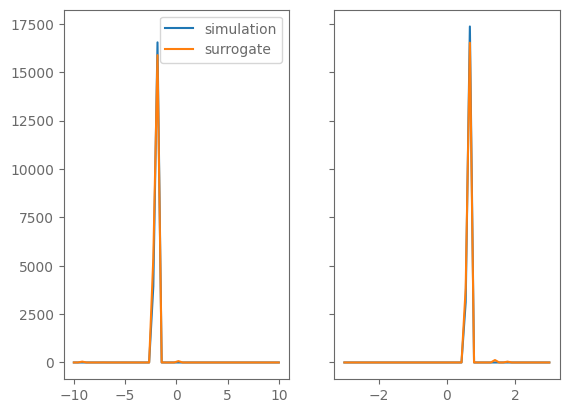

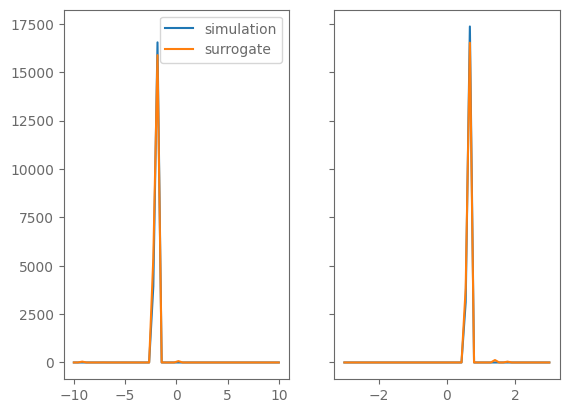

In [4]:
Plot.plot_engines_comparison(engine, surrogate_engine, [tensor_to_param_container(torch.ones((34))*0.5)], MultiLayer([0.]))

# Datamodule

In [8]:
load_len: int | None = 10000
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/data_raw_*.h5'))
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': surrogate_engine.model.standardizer}))


bal_memory_dataset = BalancedMemoryDataset(dataset=dataset, load_len=load_len, min_n_rays=500)
memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)
datamodule = DefaultDataModule(dataset=bal_memory_dataset, num_workers=4)
datamodule.prepare_data()
datamodule.setup(stage="test")
test_dl = datamodule.test_dataloader()

unbal_datamodule = DefaultDataModule(dataset=memory_dataset, num_workers=4)
unbal_datamodule.prepare_data()
unbal_datamodule.setup(stage="test")
unbal_test_dl = unbal_datamodule.test_dataloader()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:57<00:00, 42.09it/s]


## Maximums distribution

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.23it/s]


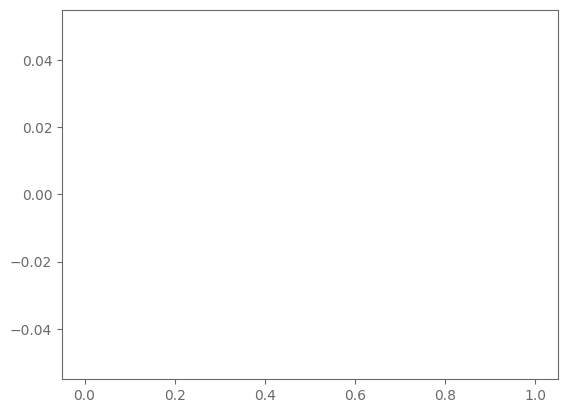

In [9]:
value_list = []
params_list = []

for i in tqdm.tqdm(unbal_test_dl):
    biggest = i[1].flatten(start_dim=1)
    biggest, _ = i[1].flatten(start_dim=1).max(dim=1)
    mask = biggest > 0.8
    value_list.append(biggest[mask])
    params_list.append(i[0][mask])
value_tensor = torch.cat(value_list)
params_tensor = torch.cat(params_list)

torch.save(value_tensor, 'outputs/values.pt')
torch.save(params_tensor, 'outputs/params.pt')
plt.hist(value_tensor)
plt.savefig('outputs/max_dist_hist.png')

In [5]:
value_tensor = torch.load('outputs/values.pt')
params_tensor = torch.load('outputs/params.pt')

/tmp/ipykernel_9029/3069755826.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  value_tensor = torch.load('outputs/values.pt')
/tmp/ipykernel_9029/3069755826.py:2: Future

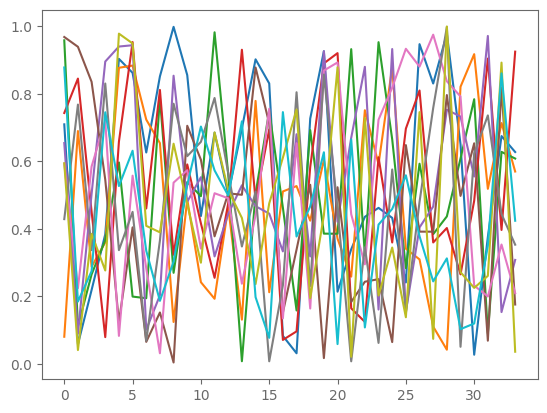

# Special sample

In [5]:
with open("observed_params.pkl", "rb") as f:
    observed_params = pickle.load(f, fix_imports=True, encoding='ASCII', errors='strict', buffers=None)
for param_container in observed_params:
    for label in ['ImagePlane.translationXerror', 'ImagePlane.translationYerror', 'ImagePlane.translationZerror']:
        if label in list(param_container.keys()):
            del param_container[label]

/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654

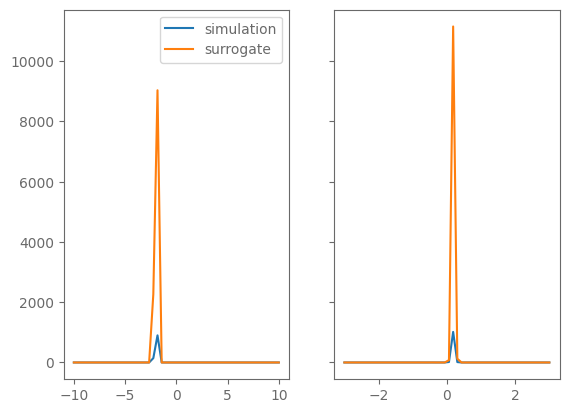

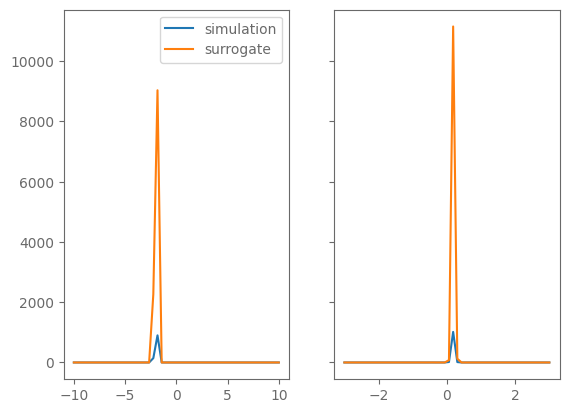

In [15]:
Plot.plot_engines_comparison(engine, surrogate_engine, observed_params[:1], MultiLayer([0.]), )

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1723679.375, 1915673.25 , 2107667.25 , 2299661.   , 2491655.   ,
        2683648.75 , 2875642.75 , 3067636.5  , 3259630.5  , 3451624.25 ,
        3643618.25 ]),
 <BarContainer object of 10 artists>)

<Figure size 640x480 with 0 Axes>

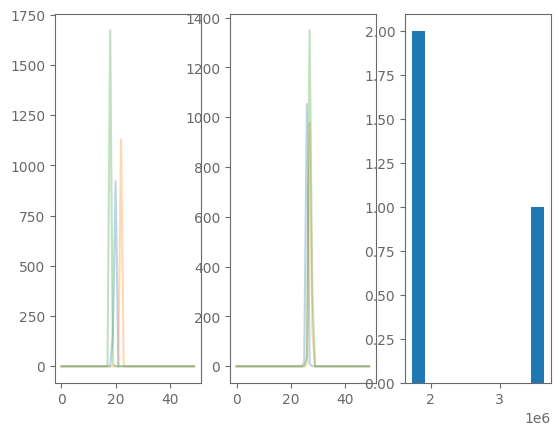

In [54]:
mse_comparison, x_simulation_hist, y_simulation_hist = mse_engines_comparison(engine, surrogate_engine, observed_params[:3], MultiLayer([0.]))
plt.clf()
fig, ax = plt.subplots(1, 3)
for hist in x_simulation_hist:
    ax[0].plot(hist, alpha=0.3)
for hist in y_simulation_hist:
    ax[1].plot(hist, alpha=0.3)
ax[2].hist(mse_comparison)

In [16]:
x_loc_list = []
good_param_list = []
batch_size = 5000
for i in tqdm.trange(15000//batch_size):
    param_container = [tensor_to_param_container(torch.rand((34,))) for _ in range(batch_size)]
    surrogate_out = surrogate_engine.run(param_container, MultiLayer([0.]))
    for j in range(len(param_container)):
        output = surrogate_out[j]['ray_output']['ImagePlane']['xy_hist']
        if output.x_loc.sum() > 0.5:
            x_loc_list.append(output.x_loc.sum())
            good_param_list.append(param_container[j])

observed_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in observed_params])
good_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in good_param_list])

  0%|                                                                                                                                                                             | 0/3 [00:00<?, ?it/s]/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/pytho

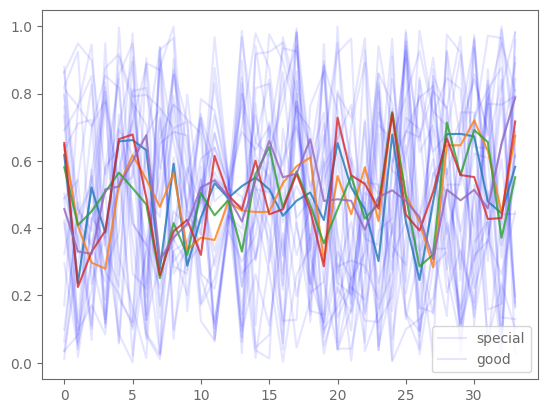

In [52]:
plt.clf()
for i in range(good_containers_tensor.shape[0]):
    plt.plot(good_containers_tensor[i], c = 'blue', alpha=0.1)
for i in range(observed_containers_tensor.shape[0]-10):
    plt.plot(observed_containers_tensor[i], alpha=0.8)
plt.legend(["special", "good"])

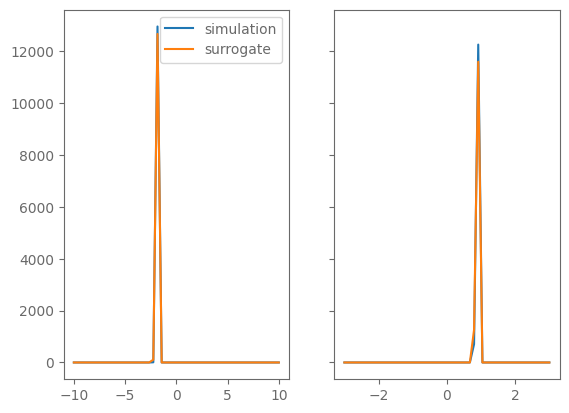

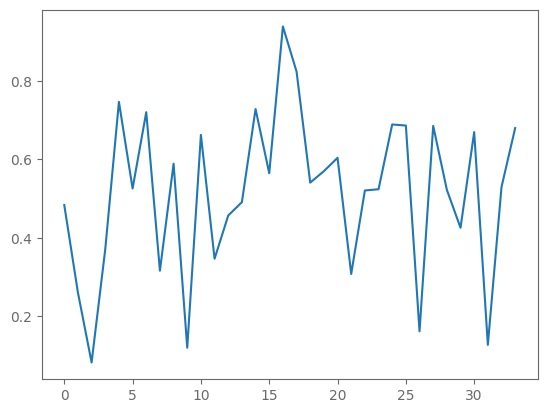

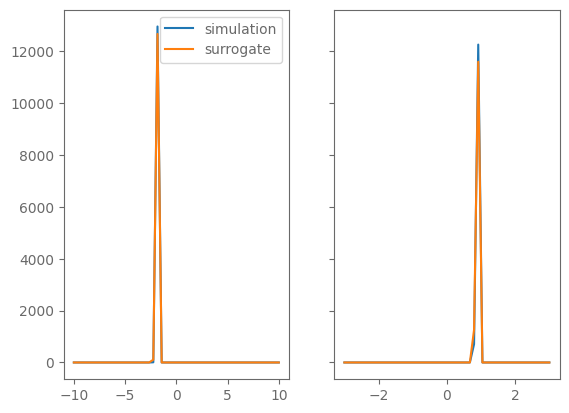

In [43]:
#mask = value_tensor > 0.44
out = ((params_tensor - observed_containers_tensor[0].unsqueeze(0))**2)/2.
out = out.mean(dim=1)
out_sorted, indices = torch.sort(out)
#part_indices = indices[:5]
#print(part_indices.shape)
#min_arg = out.argmin()
#plt.hist(out.mean(dim=1))
#plt.plot(params_tensor[min_arg])
#plt.plot(observed_containers_tensor[0])
for i in indices[:1]:
    plt.plot(params_tensor[i])
Plot.plot_engines_comparison(engine, surrogate_engine, [tensor_to_param_container(params_tensor[min_arg]) for min_arg in indices[:1]], MultiLayer([0.]), )

In [24]:
#surrogate_engine.run(observed_params)
model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx_copy/checkpoints/epoch=186-step=45716638.ckpt")
select = Select(keys=['1e5/params'], omit_ray_params=['U41_318eV.numberRays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': model.standardizer})
param_containers_tensor = torch.vstack([select({"1e5/params":param_container})[0] for param_container in observed_params])
with torch.no_grad():
    out_model = model(param_containers_tensor)


/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/dmeier/.venv/lib64/python3.11/site-packages/t

Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


In [34]:
transforms = {"ImagePlane": transform for transform in cfg_transforms}
out_engine = engine.run(observed_params, transforms)

In [53]:
standardized_simulations = surrogate_engine.model.standardizer(torch.vstack([element['ray_output']['ImagePlane']['histogram'].flatten(start_dim=0) for element in out_engine]))
a = ((standardized_simulations - out_model)**2).mean(dim=1)

(array([2., 3., 2., 2., 2., 0., 0., 2., 1., 1.]),
 array([0.0007691 , 0.00143994, 0.00211078, 0.00278163, 0.00345247,
        0.00412331, 0.00479415, 0.00546499, 0.00613584, 0.00680668,
        0.00747752]),
 <BarContainer object of 10 artists>)

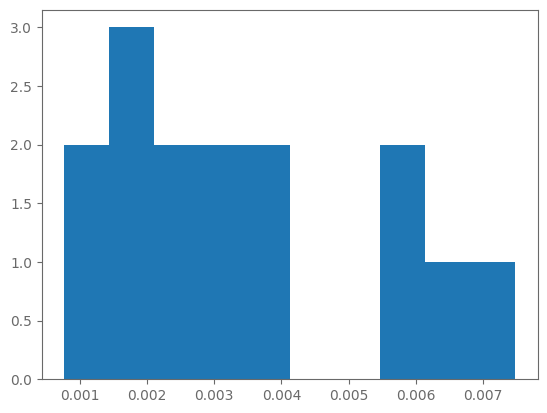

In [55]:
plt.hist(a)

# Good params vs. bad params

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 373165.36it/s]


(array([9.812e+03, 5.500e+01, 2.600e+01, 3.300e+01, 2.400e+01, 2.100e+01,
        1.000e+01, 1.100e+01, 7.000e+00, 1.000e+00]),
 array([    0. ,  1400.5,  2801. ,  4201.5,  5602. ,  7002.5,  8403. ,
         9803.5, 11204. , 12604.5, 14005. ]),
 <BarContainer object of 10 artists>)

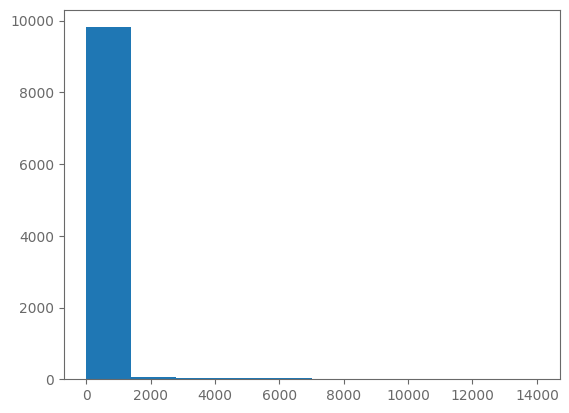

In [66]:
params_list = []
num_rays_list = []
for i in tqdm.tqdm(memory_dataset):
    params_list.append(i[0])
    num_rays_list.append(i[2])
params_tensor = torch.vstack(params_list)
num_rays_tensor= torch.vstack(num_rays_list)
plt.hist(torch.tensor(num_rays_list))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:45<00:00,  8.27s/it]


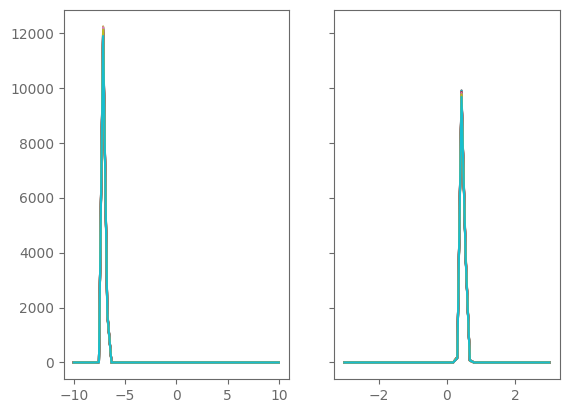

In [74]:
biggest = torch.tensor(num_rays_list).argmax()
test_parameters = memory_dataset[biggest][0]
param_container_list = [tensor_to_param_container(test_parameters)]

fig, ax = plt.subplots(1,2, sharey=True, squeeze=False)

for i in tqdm.trange(20):
    out = engine.run(param_container_list, MultiLayer([0.]))
    out_simulation = out[-1]['ray_output']['ImagePlane']['0.0']
    x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
    y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
    ax[0, 0].plot(torch.linspace(-10, 10, 50), x_simulation_hist)
    ax[0, 1].plot(torch.linspace(-3, 3, 50), y_simulation_hist)

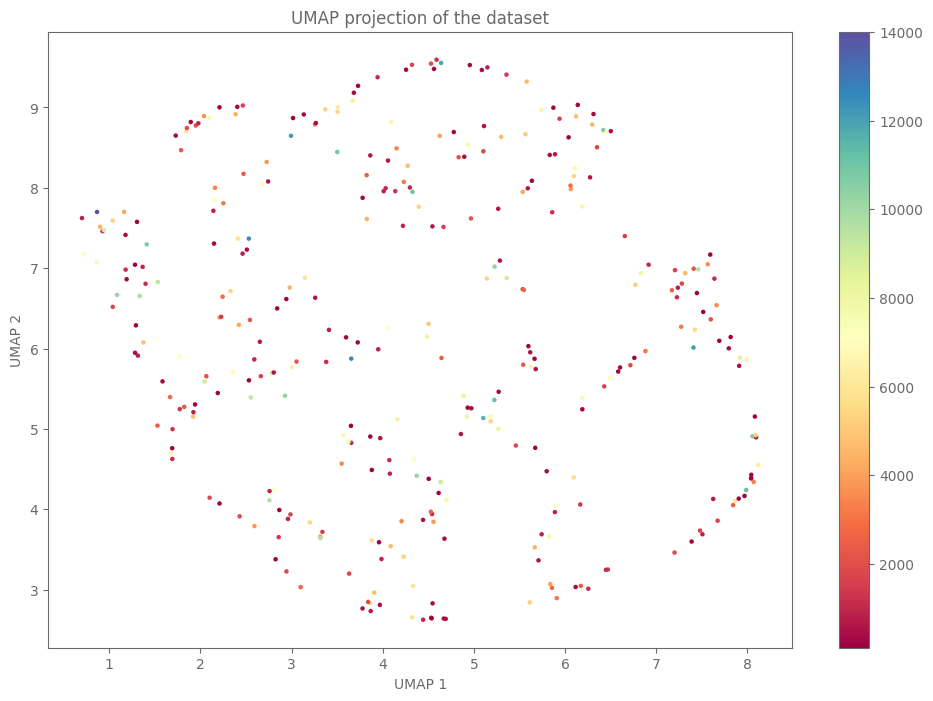

In [27]:
import umap
mask = num_rays_tensor > 100.
data_tensor = params_tensor[mask.flatten()]
data_tensor = data_tensor[:,:4]
class_tensor = num_rays_tensor[mask]

data_np = data_tensor.numpy()
class_np = class_tensor.numpy().flatten()

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_embedding = umap_model.fit_transform(data_np)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

/home/dmeier/.venv/lib64/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


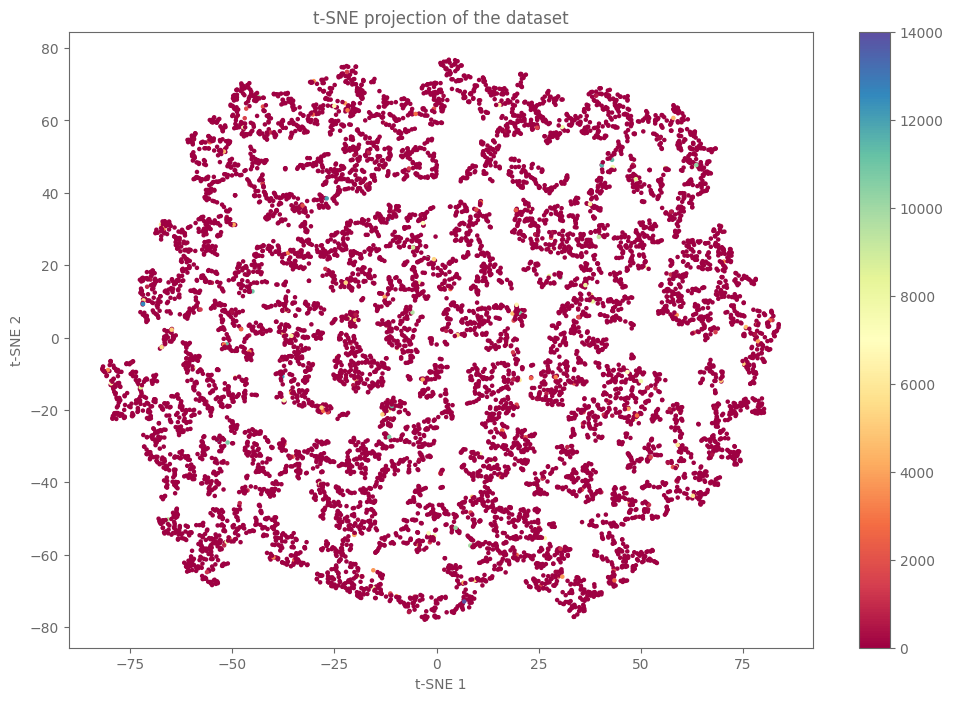

In [26]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000)
tsne_embedding = tsne_model.fit_transform(data_np)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('t-SNE projection of the dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [6]:
import glob
import tqdm
import matplotlib.pyplot as plt
import torch

from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate, StandardizeXYHist
from ray_tools.simulation.torch_datasets import MemoryDataset, RayDataset
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from torch.utils.data import DataLoader
from ray_nn.data.transform import Select


model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx/checkpoints/epoch=174-step=42782950.ckpt")
model.to(torch.device('cpu'))
model.compile()
model.eval()

load_len: int | None = None
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/selected/data_raw_*.h5'))
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': model.standardizer}))


memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)

train_dataloader = DataLoader(memory_dataset, batch_size=2048, shuffle=False, num_workers=0)

errors_list = []
with torch.no_grad():
    for par_input, label, _ in tqdm.tqdm(train_dataloader):
        out = model(par_input)
        label = label.flatten(start_dim=1)
        b = ((label - out)**2).mean(dim=1)
        errors_list.append(b)
errors_tensor = torch.cat(errors_list)

plt.hist(errors_tensor)
plt.savefig('outputs/dataset_errors_hist.png')
torch.save(errors_tensor, 'outputs/dataset_errors.pt')

/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


  0%|                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/pytho